In [3]:
!nvidia-smi

Wed Apr 17 07:27:28 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:B7:00.0 Off |                    0 |
| N/A   27C    P0    70W / 400W |   1820MiB / 40536MiB |     29%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [146]:
import base64
import io
import json
import os
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from irrCAC.raw import CAC
from PIL import Image

# change to /vqa-sdg if current base working directory is not that:
if os.getcwd().split("/")[-1] != "vqa-sdg":
    os.chdir("vqa-sdg")

In [147]:
TEST_NAMES = [
    "10-4_vicuna7_naive-optim_500",
    "10-4_vicuna13_naive-optim_500",
    "10-4_vicuna13_qg-story-optim_500",
    "10-4_vicuna13-vip_nonvis-optim_500"
]

In [155]:
def transform_raw_to_dfs(
    test_name: str, sheet_name: str = "scoresheet"
) -> List[pd.DataFrame]:
    xlsx_dir = f"./result/{test_name}/eval/xlsx/"
    dfs = []

    for file in os.listdir(xlsx_dir):
        filename, ext = os.path.splitext(file)
        evaluator = filename.split("_")[-1]
        df = None

        if ext == ".xlsx":
            df = pd.read_excel(xlsx_dir + file, sheet_name=sheet_name)[
                [
                    "id",
                    "img_id",
                    "accuracy",
                    "logical",
                    "clarity",
                    "detail",
                    "irrelevancy",
                ]
            ]
        elif ext == ".csv":
            df = pd.read_csv(xlsx_dir + file)[
                [
                    "id",
                    "img_id",
                    "accuracy",
                    "logical",
                    "clarity",
                    "detail",
                    "irrelevancy",
                ]
            ]

        df["evaluator"] = evaluator
        dfs.append(df)

    return dfs

def get_clean_df(df: pd.DataFrame) -> Tuple[pd.DataFrame, float]:
    df.dropna(subset=["accuracy", "logical", "clarity", "detail", "irrelevancy"], inplace=True)

    clean_df = df[(df != -1.0).all(axis=1)]
    clean_rate = len(clean_df) / len(df)

    return clean_df, clean_rate

In [ ]:
def common_ids(dfs):
    if not dfs:
        return set()

    common_ids_set = set(dfs[0]["id"])
    for df in dfs[1:]:
        common_ids_set &= set(df["id"])

    return common_ids_set


def dfs_to_CAC(dfs):
    METRICS = ["accuracy", "logical", "clarity", "detail", "irrelevancy"]
    CACs = {}

    common_ids_set = common_ids(dfs)

    for metric in METRICS:
        series = [df[df["id"].isin(common_ids_set)][metric] for df in dfs]
        cols = [f"rater_{i}" for i in range(1, len(dfs) + 1)]
        CACs[metric] = pd.concat(series, keys=cols, axis=1)

    return CACs


def gwet_AC2(test_name, weights="ordinal"):
    transformed_dfs = transform_raw_to_dfs(test_name)
    print(len(transformed_dfs))

    cac_by_metric_dict = dfs_to_CAC(transformed_dfs)
    gwet_by_metric_dict = {}

    scores = []
    for metric, cac in cac_by_metric_dict.items():
        cac_metric = CAC(cac, weights=weights)

        score = cac_metric.gwet()["est"]["coefficient_value"]
        gwet_by_metric_dict[metric] = score
        scores.append(score)

    gwet_by_metric_dict["overall"] = sum(scores) / len(scores)

    return gwet_by_metric_dict

: 

In [206]:
def gen_subjective_quant_analysis(test_names: List[str]) -> dict:
    res = {}

    for test in test_names:
        transformed_dfs = transform_raw_to_dfs(test)
        cleaned_transformed_dfs = [get_clean_df(df) for df in transformed_dfs]

        cleaned_dfs = [df for df, _ in cleaned_transformed_dfs]
        clean_rate = [rate for _, rate in cleaned_transformed_dfs]

        common_ids_set = common_ids(cleaned_dfs)
        mutual_dfs = [df[df["id"].isin(common_ids_set)] for df in cleaned_dfs]

        metric = ["accuracy", "logical", "clarity", "detail", "irrelevancy"]
        mean_scores = [df[metric].mean() for df in mutual_dfs]
        ovr_mean_scores = pd.concat(mean_scores, axis=1).mean(axis=1)
        ovr_std_scores = pd.concat(mean_scores, axis=1).std(axis=1)

        mean_scores = [mean_scores[i].to_dict() for i in range(len(mean_scores))]

        res[test] = {
            "amount": len(common_ids_set),
            "clean_rate": np.mean(clean_rate),
            "mean_scores_per_sample": mean_scores,
            "ovr_mean_scores": ovr_mean_scores.to_dict(),
            "ovr_std_scores": ovr_std_scores.to_dict(),
        }
    
    return res

In [209]:
import json

def gen_quant_subj_df(test_names: List[str], export_detail: bool = False) -> pd.DataFrame:
    quant_subj_res = gen_subjective_quant_analysis(test_names)

    res = {}
    for test_name, data in quant_subj_res.items():
        if export_detail:
            with open(f"./result/{test_name}/eval/quant_subj.json", "w") as f:
                json.dump(quant_subj_res[test_name], f)

        res[test_name] = {
            "amount": data["amount"],
            "clean_rate": data["clean_rate"],
            **{f"avg_{metric}": data["ovr_mean_scores"][metric] for metric in data["ovr_mean_scores"].keys()},
            **{f"std_{metric}": data["ovr_std_scores"][metric] for metric in data["ovr_std_scores"].keys()}
        }

    return round(pd.DataFrame(res).T, 2)

In [235]:
gen_quant_subj_df(TEST_NAMES)

,amount,clean_rate,avg_accuracy,avg_logical,avg_clarity,avg_detail,avg_irrelevancy,std_accuracy,std_logical,std_clarity,std_detail,std_irrelevancy
10-4_vicuna7_naive-optim_500,42.0,0.84,2.50,2.55,2.90,2.57,1.64,0.0,0.0,0.0,0.0,0.0
10-4_vicuna13_naive-optim_500,55.0,1.00,2.49,2.27,2.87,2.56,1.40,NaN,NaN,NaN,NaN,NaN
10-4_vicuna13_qg-story-optim_500,50.0,1.00,2.38,2.16,2.86,2.72,1.84,NaN,NaN,NaN,NaN,NaN
10-4_vicuna13-vip_nonvis-optim_500,49.0,0.98,2.61,2.43,2.94,2.69,1.20,NaN,NaN,NaN,NaN,NaN


In [246]:
import numpy as np
def gen_subj_rank(test_names: List[str], map_index: dict = None) -> pd.DataFrame:
    quant_subj_res = gen_subjective_quant_analysis(test_names)
    res = {}
    for test_name, data in quant_subj_res.items():
        content = data["ovr_mean_scores"]
        content["clean_rate"] = data["clean_rate"]
        content["amount"] = data["amount"]
        res[test_name] = content

    df = pd.DataFrame(res).T

    if map_index:
        df.rename(index=map_index, inplace=True)

    rank_df = pd.DataFrame(index=[i + 1 for i in range(len(df.index))], columns=df.columns)
    
    for col in df.columns:
        asc = True if col == "irrelevancy" else False
        ranked_idx = df.sort_values(by=col, ascending=asc)[col].index
        ranked_val = np.round(df.sort_values(by=col, ascending=asc)[col].values, 2)

        rank_df[col] = [f"{ranked_idx[i]} - ({ranked_val[i]})" for i in range(len(ranked_idx))]

    return rank_df

In [247]:
gen_subj_rank(TEST_NAMES, {
    "10-4_vicuna13-vip_nonvis-optim_500" : "13b_nonvis",
    "10-4_vicuna7_naive-optim_500": "7b_naive",
    "10-4_vicuna13_naive-optim_500": "13b_naive",
    "10-4_vicuna13_qg-story-optim_500": "13b_qg-story",
})

,accuracy,logical,clarity,detail,irrelevancy,clean_rate,amount
1,13b_nonvis - (2.61),7b_naive - (2.55),13b_nonvis - (2.94),13b_qg-story - (2.72),13b_nonvis - (1.2),13b_naive - (1.0),13b_naive - (55.0)
2,7b_naive - (2.5),13b_nonvis - (2.43),7b_naive - (2.9),13b_nonvis - (2.69),13b_naive - (1.4),13b_qg-story - (1.0),13b_qg-story - (50.0)
3,13b_naive - (2.49),13b_naive - (2.27),13b_naive - (2.87),7b_naive - (2.57),7b_naive - (1.64),13b_nonvis - (0.98),13b_nonvis - (49.0)
4,13b_qg-story - (2.38),13b_qg-story - (2.16),13b_qg-story - (2.86),13b_naive - (2.56),13b_qg-story - (1.84),7b_naive - (0.84),7b_naive - (42.0)


In [210]:
gen_quant_subj_df(TEST_NAMES)

,amount,clean_rate,avg_accuracy,avg_logical,avg_clarity,avg_detail,avg_irrelevancy,std_accuracy,std_logical,std_clarity,std_detail,std_irrelevancy
10-4_vicuna7_naive-optim_500,42.0,0.84,2.50,2.55,2.90,2.57,1.64,0.0,0.0,0.0,0.0,0.0
10-4_vicuna13_naive-optim_500,55.0,1.00,2.49,2.27,2.87,2.56,1.40,NaN,NaN,NaN,NaN,NaN
10-4_vicuna13_qg-story-optim_500,50.0,1.00,2.38,2.16,2.86,2.72,1.84,NaN,NaN,NaN,NaN,NaN
10-4_vicuna13-vip_nonvis-optim_500,49.0,0.98,2.61,2.43,2.94,2.69,1.20,NaN,NaN,NaN,NaN,NaN


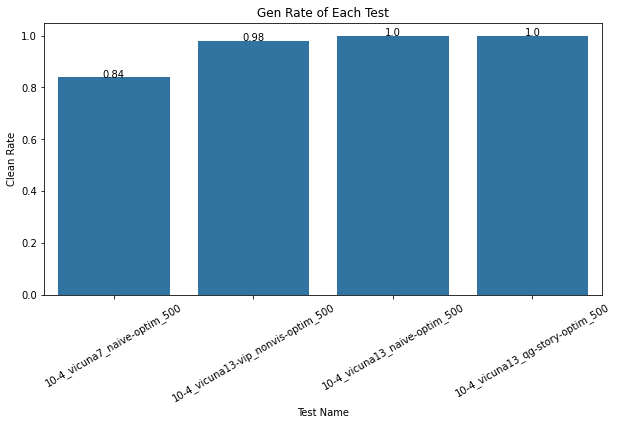

In [98]:
# visualize the clean rate in form of bar chart
import seaborn as sns
import matplotlib.pyplot as plt

clean_rate_df = pd.DataFrame(clean_rate_test.items(), columns=["Test Name", "Clean Rate"])

clean_rate_df = clean_rate_df.sort_values(by="Clean Rate").reset_index(drop=True)

plt.figure(figsize=(10, 5))
sns.barplot(x="Test Name", y="Clean Rate", data=clean_rate_df)
plt.title("Gen Rate of Each Test")

for index, row in clean_rate_df.iterrows():
    plt.text(index, row["Clean Rate"], round(row["Clean Rate"], 2), color='black', ha="center")

# rotate x axis 30 degree
plt.xticks(rotation=30)

plt.show()

In [101]:
# using cleaned_df_tests, get the average of every accuracy, logical, clarity, detail, irrelevancy column
average_scores = {}

for test in cleaned_dfs_tests:
    df = cleaned_dfs_tests[test]
    average_scores[test] = df[["accuracy", "logical", "clarity", "detail", "irrelevancy"]].mean()

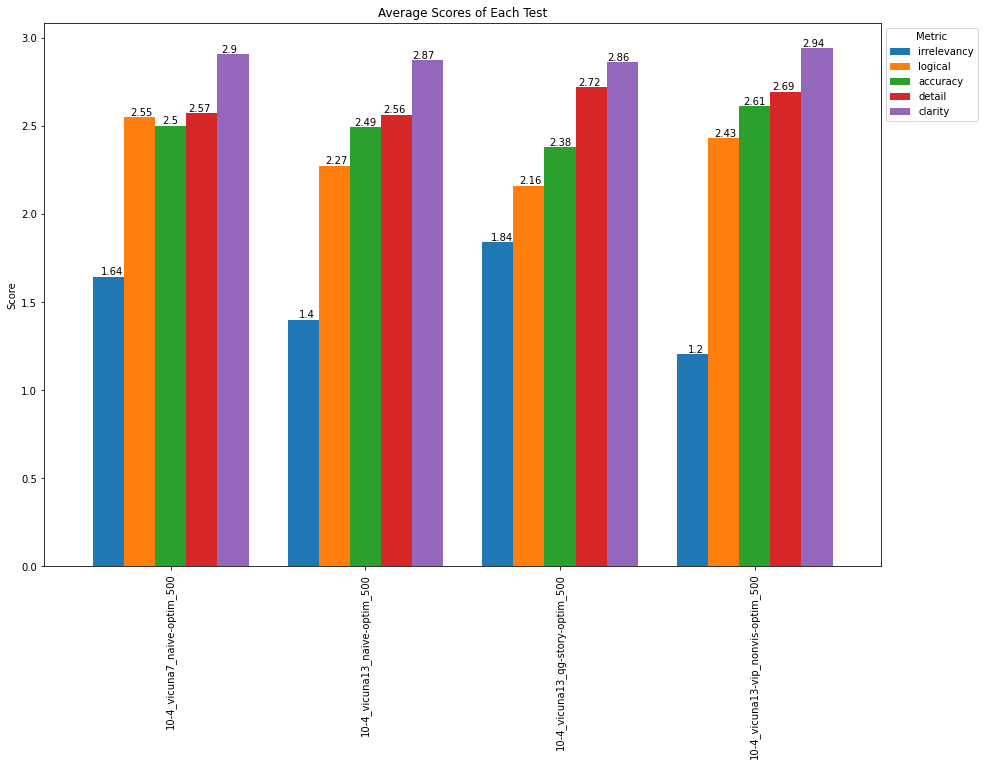

In [124]:
# now, visualize it in form of bar chart, with every test name separated into 5 sub-bar that represents each of the metrics
average_scores_df = pd.DataFrame(average_scores).T
average_scores_df = average_scores_df[["irrelevancy", "logical", "accuracy", "detail", "clarity"]]


fig = plt.figure(figsize=(15, 10))  # Create figure and set size
ax = fig.add_subplot(111)  # Add a subplot to the figure

average_scores_df.plot(kind="bar", stacked=False, width=0.8, ax=ax)  # Plot on the axes
plt.title("Average Scores of Each Test")
plt.ylabel("Score")

# show a legend that denotes each color corresponds to what metric
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Metric")

# also show the value of each bar
for i in range(average_scores_df.shape[0]):
    for j in range(average_scores_df.shape[1]):
        plt.text(
            i + (j - 2) * 0.15,
            average_scores_df.iloc[i, j],
            round(average_scores_df.iloc[i, j], 2),
            ha="center",
            va="bottom",
        )

plt.show()

In [56]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


     |████████████████████████████████| 294 kB 2.4 MB/s eta 0:00:01


In [47]:
def get_clean_df(df: pd.DataFrame, sample_size: int = 50) -> Tuple[pd.DataFrame, float]:
    clean_df = df[(df != -1.0).all(axis=1) & (df.notnull().all(axis=1))]
    clean_rate = len(clean_df) / sample_size

    return clean_df, clean_rate

In [33]:
df_clean, clean_rate = get_clean_df(dfs[0])

In [34]:
clean_rate

0.84

In [35]:
df_clean

,id,img_id,accuracy,logical,clarity,detail,irrelevancy,evaluator
0,32,1159351.jpg,3.0,3.0,3.0,3.0,1.0,Patrick
1,31,1159351.jpg,3.0,3.0,3.0,3.0,2.0,Patrick
2,169,1592305.jpg,2.0,3.0,3.0,3.0,2.0,Patrick
4,292,2317271.jpg,3.0,3.0,3.0,3.0,1.0,Patrick
5,57,2320752.jpg,3.0,3.0,3.0,3.0,3.0,Patrick
6,58,2320752.jpg,3.0,3.0,3.0,3.0,3.0,Patrick
8,117,2325198.jpg,2.0,3.0,3.0,3.0,1.0,Patrick
9,119,2325198.jpg,3.0,3.0,3.0,3.0,1.0,Patrick
10,234,2326805.jpg,2.0,2.0,3.0,3.0,1.0,Patrick
11,74,2328035.jpg,2.0,2.0,3.0,3.0,2.0,Patrick
